### ML pipelines

In [1]:
import ads
from ads.pipeline.ads_pipeline_step import PipelineStep
from ads.pipeline.ads_pipeline import Pipeline
from ads.pipeline import CustomScriptStep
from ads.jobs import ScriptRuntime

In [2]:
ads.set_auth(auth="resource_principal")

In [3]:
project_id = "ocid1.datascienceproject.oc1.eu-milan-1.amaaaaaangencdyageryq6wvsxw6rjdjwagoym3h7hnncszqqnq34g3aakoq"
compartment_id="ocid1.compartment.oc1..aaaaaaaag2cpni5qj6li5ny6ehuahhepbpveopobooayqfeudqygdtfe6h3a"
log_group_id = "ocid1.loggroup.oc1.eu-milan-1.amaaaaaangencdya37xpdas7cenw3thhfetpb5qe75ymyymoo2b4w42pbrsq"
pipeline_name = "emp-pipe5"

In [6]:
# use the same infrastructure for all steps to save some code. You can choose to use a different infrastructure for each step.
infrastructure = (
    CustomScriptStep()  # using a python script as the step code. ML Jobs and Notebook files are supported as well.
    .with_block_storage_size(50)
    .with_shape_name("VM.Standard2.4")
)
 
# define the data processing step
step_data_processing = (
    PipelineStep("data_processing")
    .with_description("Import data, feature engineering, train-test split")
    .with_infrastructure(infrastructure)
    .with_maximum_runtime_in_minutes(30)
    .with_runtime(
        ScriptRuntime()
        .with_source("employee-attr-dataproc.zip")  # this is the step’s artifact. It includes all the files necessary to execute the step.
        .with_service_conda("onnx110_p37_cpu_v1")   # using data science conda pack. custom published packs are also supported
        .with_environment_variable(PIPELINE_STEP_RUN_ENTRYPOINT="employee-attr-dataproc.py")    # define the main script in the artifact to execute.
    )
)
 
# define the logistic regression training step
step_train_logistic_regression = (
    PipelineStep("train_logistic_regression")
    .with_description("Train a Logistic Regression model and save to the model catalog with its AUC score")
    .with_infrastructure(infrastructure)
    .with_maximum_runtime_in_minutes(120)
    .with_runtime(
        ScriptRuntime()
        .with_source("employee-attr-train-lr.zip")
        .with_service_conda("onnx110_p37_cpu_v1")
        .with_environment_variable(PIPELINE_STEP_RUN_ENTRYPOINT="employee-attr-train-lr.py")
    )
)
 
# define the random forest training step
step_train_random_forest = (
    PipelineStep("train_random_forest")
    .with_description("Train a Random Forest model and save to the model catalog with its AUC score")
    .with_infrastructure(infrastructure)
    .with_maximum_runtime_in_minutes(120)
    .with_runtime(
        ScriptRuntime()
        .with_source("employee-attr-train-rf.zip")
        .with_service_conda("onnx110_p37_cpu_v1")
        .with_environment_variable(PIPELINE_STEP_RUN_ENTRYPOINT="employee-attr-train-rf.py")
    )
)
 
# define the xgboost training step
step_train_xgboost = (
    PipelineStep("train_xgboost")
    .with_description("Train a model with XGBoost and save to the model catalog with its AUC score")
    .with_infrastructure(infrastructure)
    .with_maximum_runtime_in_minutes(120)
    .with_runtime(
        ScriptRuntime()
        .with_source("employee-attr-train-xgb.zip")
        .with_service_conda("onnx110_p37_cpu_v1")
        .with_environment_variable(PIPELINE_STEP_RUN_ENTRYPOINT="employee-attr-train-xgb.py")
    )
)
 
# define the model evaluation and deploy step
step_evaluate_and_deploy = (
    PipelineStep("evaluate_and_deploy")
    .with_description("Find the best model by their AUC score and deploy")
    .with_infrastructure(infrastructure)
    .with_maximum_runtime_in_minutes(30)
    .with_runtime(
        ScriptRuntime()
        .with_source("employee-attr-eval-deploy.zip")
        .with_service_conda("onnx110_p37_cpu_v1")
        .with_environment_variable(PIPELINE_STEP_RUN_ENTRYPOINT="employee-attr-eval-deploy.py")
    )
)
 
# define the pipeline
pipeline = (
    Pipeline(pipeline_name)
    .with_compartment_id(compartment_id)
    .with_project_id(project_id)
    .with_log_group_id(log_group_id)  # if you define the LogGroupID but not the LogID, logs will be created automatically in the specified LogGroup
    .with_freeform_tags({"pipeline-sample":"employee-attrition-sample"})
    .with_step_details([step_data_processing, step_train_logistic_regression, step_train_random_forest, step_train_xgboost, step_evaluate_and_deploy])    # set the steps to include in the pipeline
    .with_dag(["data_processing >> (train_logistic_regression, train_random_forest, train_xgboost) >> evaluate_and_deploy"])  # define the DAG
)

In [7]:
pipeline.create()

kind: pipeline
spec:
  compartmentId: ocid1.compartment.oc1..aaaaaaaag2cpni5qj6li5ny6ehuahhepbpveopobooayqfeudqygdtfe6h3a
  dag:
  - data_processing >> (train_logistic_regression, train_random_forest, train_xgboost)
    >> evaluate_and_deploy
  displayName: emp-pipe5
  freeformTags:
    pipeline-sample: employee-attrition-sample
  id: ocid1.datasciencepipeline.oc1.eu-milan-1.amaaaaaangencdya2vn5ieguh6gebklgpsd57ijhjygomaawlqdxc5dcwyuq
  logGroupId: ocid1.loggroup.oc1.eu-milan-1.amaaaaaangencdya37xpdas7cenw3thhfetpb5qe75ymyymoo2b4w42pbrsq
  projectId: ocid1.datascienceproject.oc1.eu-milan-1.amaaaaaangencdyageryq6wvsxw6rjdjwagoym3h7hnncszqqnq34g3aakoq
  stepDetails:
  - kind: customScript
    spec:
      description: Import data, feature engineering, train-test split
      infrastructure:
        kind: infrastructure
        spec:
          blockStorageSize: 50
          shapeName: VM.Standard2.4
      name: data_processing
      runtime:
        kind: runtime
        spec:
          con

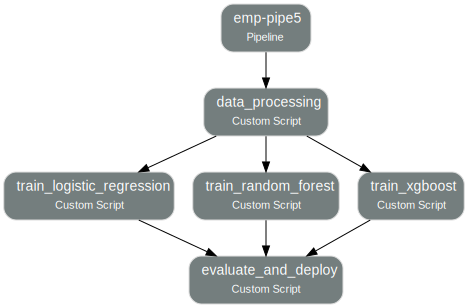

In [8]:
pipeline.show()

In [9]:
pipeline_run = pipeline.run()

In [ ]:
pipeline_run.watch()